# OptionalLab8
# Jie Liu EOSC 511

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import importlib as imp
import time
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [2]:
def param():
    # set the physical parameters of the system
    Av = 5.e-2           # vertical eddy viscosity (m^2/s)
    H = 500.               # depth (m)
    rho = 1.0e3            # density of water (kg/m^3)
    latitude = 45.         # for calculating parameters of the beta-plane (deg)
    tau_max = 0.2          # wind stress maximum (kg m/s^2)
    b = 2.0e6              # width of the ocean (m)
    a = 2.0e6              # N-S extent of the ocean (m)

    # necessary constants
    omega =  7.272205e-05  # rotation rate of the Earth (/s)
    earth_radius = 6.4e+6  # radius of the Earth (m)

    # calculate derived parameters
    theta = latitude/360*2*np.pi               # convert degrees to radians
    beta = 2*omega*np.cos(theta)/earth_radius  # beta=df/dy
    f0 = 2*omega*np.sin(theta)                 # Coriolis parameter
    kappa = np.sqrt(Av*f0/2)/H                 # Ekman number = delta/H
    boundary_layer_width_approx = kappa/beta   # estimate of BL width (m)

    # calculation the three nondimensional coefficients
    U0 = tau_max/(b*beta*rho*H)
    epsilon = U0/(b*b*beta)
    wind = -1.
    vis = kappa/(beta*b)
    time = 1./(beta*b)

    # display physical parameters
    print ("Physical Parameters:")
    print ("a = ", a)
    print ("b = ", b)
    print ("epsilon = ", epsilon)
    print ("wind = ", wind)
    print ("vis = ", vis)
    print ("time = ", time)
    print ("boundary_layer_width_approx = ", boundary_layer_width_approx)

    return (b, a, epsilon, wind, vis, time)

def numer_init(loop, flag):
    # set up domain
    nx = 30            # number of points in x-direction
    dx = 1./(nx-1)     # size of non-dimensional grid points
    ny = int(1./dx+1)  # number of points in y-direction

    # set time step
    dt = 43.2e3  # time step  

    # set up the parameters for the relaxation scheme
    tol = 0.5e-2   # error tolerance
    maxiter = 50     # maximum number of interation
    if loop & (flag =='SOR'):
        coeff = 1.7  # relaxation coefficient
    else:
        coeff = 1.

    # display simulation parameters
    print ("\nSimulation Parameters:")
    print ("nx = ", nx)
    print ("dx = ", dx)
    print ("ny = ", ny)
    print ("dt = ", dt)
    print ("maximum iterations = ", maxiter)
    print ("tolerance =", tol )
    print ("coeff = ", coeff)

    return (nx, dx, ny, dt, tol, maxiter, coeff)

def vis(psi, nx, ny):
    visc = np.zeros_like(psi)
    
    # loop version
    ## for i in range(1, nx-1):
    ##     for j in range(1, ny-1):
    ##         visc[i,j] = psi[i+1,j]+psi[i-1,j]+psi[i,j+1]+psi[i,j-1]-4*psi[i,j]

    # indexing version
    si = 1; ei = nx-1 # start and end i indices
    sj = 1; ej = ny-1 # start and end j indices
    visc[si:ei, sj:ej] = (
        psi[si+1:ei+1, sj:ej] + psi[si-1:ei-1, sj:ej] +
        psi[si:ei, sj+1:ej+1] + psi[si:ei, sj-1:ej-1]
        - 4 * psi[si:ei, sj:ej])

    return visc

def mybeta(psi,nx,ny):
    beta = np.zeros_like(psi)

    # loop version
    ## for i in range(1,nx-1):
    ##     for j in range(1,ny-1):
    ##         beta[i,j] = psi[i+1,j]-psi[i-1,j]

    # indexing version
    si = 1; ei = nx-1 # start and end i indices
    sj = 1; ej = ny-1 # start and end j indices
    beta[si:ei, sj:ej] = psi[si+1:ei+1, sj:ej] - psi[si-1:ei-1, sj:ej]
    return beta

def wind(nx, ny):
    windy = np.zeros((nx, ny))
                     
    # loop version
    ## for i in range(0,nx):
    ##    for j in range(0,ny):
    ##        # fit one negative cosine curve from southern boundary to northern
    ##        tau[i,j] = -np.cos(np.pi*(j-0.5)/(ny-2))

    ## for i in range(1,nx-1):
    ##    for j in range(1,ny-1):
    ##        windy[i,j] = -tau[i,j+1]+tau[i,j-1]
    
    # indexing version
    den = 1./(ny-2)
    si = 1; ei = nx-1 # start and end i indices
    sj = 1; ej = ny-1 # start and end j indices
    windy [si:ei, sj:ej] = - (
        np.cos(np.pi*(np.arange(sj, ej)+0.5) * den) -
        np.cos(np.pi*(np.arange(sj, ej)-1.5) * den)
        )
    
    return windy

def jac(psi, vis, nx, ny):
    jaco = np.zeros_like(psi)

    # loop based python version of code
    ## for i in range(1,nx-1):
    ##     for j in range(1,ny-1):
    ##         # Arakawa Jacobian
    ##         jaco[i,j] =((psi[i+1,j]-psi[i-1,j])*(vis[i,j+1]-vis[i,j-1])- \
    ##                     (psi[i,j+1]-psi[i,j-1])*(vis[i+1,j]-vis[i-1,j])+ \
    ##                     psi[i+1,j]*(vis[i+1,j+1]-vis[i+1,j-1])-psi[i-1,j]* \
    ##                     (vis[i-1,j+1]-vis[i-1,j-1])-psi[i,j+1]* \
    ##                     (vis[i+1,j+1]-vis[i-1,j+1])+psi[i,j-1]* \
    ##                     (vis[i+1,j-1]-vis[i-1,j-1])+vis[i,j+1]* \
    ##                     (psi[i+1,j+1]-psi[i-1,j+1])-vis[i,j-1]* \
    ##                     (psi[i+1,j-1]-psi[i-1,j-1])-vis[i+1,j]* \
    ##                     (psi[i+1,j+1]-psi[i+1,j-1])+vis[i-1,j]* \
    ##                     (psi[i-1,j+1]-psi[i-1,j-1]))*0.33333333
    
    # indexing version
    si = 1; ei = nx-1 # start and end i indices
    sj = 1; ej = ny-1 # start and end j indices
    jaco[si:ei, sj:ej] = (
        (psi[si+1:ei+1, sj:ej] - psi[si-1:ei-1, sj:ej]) *
        (vis[si:ei, sj+1:ej+1] - vis[si:ei, sj-1:ej-1]) -
        (psi[si:ei, sj+1:ej+1] - psi[si:ei, sj-1:ej-1]) *
        (vis[si+1:ei+1, sj:ej] - vis[si-1:ei-1, sj:ej]) +
        
        (psi[si+1:ei+1, sj:ej]) *
        (vis[si+1:ei+1, sj+1:ej+1] - vis[si+1:ei+1, sj-1:ej-1]) -
        (psi[si-1:ei-1, sj:ej]) *
        (vis[si-1:ei-1, sj+1:ej+1] - vis[si-1:ei-1, sj-1:ej-1]) -
        (psi[si:ei, sj+1:ej+1]) *
        (vis[si+1:ei+1, sj+1:ej+1] - vis[si-1:ei-1, sj+1:ej+1]) +
        (psi[si:ei, sj-1:ej-1]) *
        (vis[si+1:ei+1, sj-1:ej-1] - vis[si-1:ei-1, sj-1:ej-1]) +
        
        (vis[si:ei, sj+1:ej+1]) *
        (psi[si+1:ei+1, sj+1:ej+1] - psi[si-1:ei-1, sj+1:ej+1]) -
        (vis[si:ei, sj-1:ej-1]) *
        (psi[si+1:ei+1, sj-1:ej-1] - psi[si-1:ei-1, sj-1:ej-1]) -
        (vis[si+1:ei+1, sj:ej]) *
        (psi[si+1:ei+1, sj+1:ej+1] - psi[si+1:ei+1, sj-1:ej-1]) +
        (vis[si-1:ei-1, sj:ej]) *
        (psi[si-1:ei-1, sj+1:ej+1] - psi[si-1:ei-1, sj-1:ej-1])
        ) / 3.
    
    return jaco


def chi(psi, vis_curr, vis_prev, nx, ny, dx, epsilon, wind_par, vis_par):
    # calculate right hand side

    beta_term = mybeta(psi, nx, ny)
    wind_term = wind(nx, ny)
    jac_term = jac(psi, vis_curr, nx, ny)
    d = 1./dx

    rhs = (- 0.5*d*beta_term 
           - epsilon*0.25*d*d*d*d*jac_term
           + wind_par*0.5*d*wind_term
           - vis_par*d*d*vis_prev
          )
    
    return rhs

def relax(rhs, chi_prev, dx, nx, ny, r_coeff, tol, max_count, loop, flag):
    chi = np.copy(chi_prev)
    r = np.zeros_like(chi_prev)

    rr = 1e50
    count = 0
    
    si = 1; ei = nx-1 # start and end i indices
    sj = 1; ej = ny-1 # start and end j indices

    while (rr > tol) & (count < max_count): 
    
        if loop:  # loop based python version of code
            r_max = 0.
            chi_max = 0.
            for i in range(1, nx-1):
                for j in range(1, ny-1):
                    r[i,j] = (rhs[i,j] * dx * dx * 0.25 - 
                                ((chi[i+1, j] + chi[i, j+1] 
                                  + chi[i-1, j] + chi[i, j-1]) * 0.25 - chi[i,j]) )
                    if np.abs(chi[i,j]) > chi_max:
                            chi_max = np.abs(chi[i,j])
                    if np.abs(r[i,j]) > r_max:
                            r_max = np.abs(r[i,j])
                    if flag =='SOR':
                        chi[i,j] = chi[i,j] - r_coeff*r[i,j]
            if flag =='jacobi':
                chi[:,:] = chi[:,:]- r_coeff*r[:,:]
        else:    # index loop to use built in c-processing   
            r[si:ei, sj:ej] = rhs[si:ei, sj:ej] * dx * dx * 0.25 - (
                ( chi[si+1:ei+1, sj:ej]
                + chi[si:ei, sj+1:ej+1]
                + chi[si-1:ei-1, sj:ej]
                + chi[si:ei, sj-1:ej-1] ) * 0.25 
                - chi[si:ei, sj:ej] )
        
            chi_max = max(np.max(chi), -np.min(chi))
            r_max = max(np.max(r), -np.min(r))
            chi = chi - r_coeff * r
        
        if (chi_max==0): 
            rr = 1e50 
        else:
            rr=r_max / chi_max
        count = count + 1
    #print ('count is', count)
        
    return (chi, count)

def qg(totaltime, loop=True,flag = 'SOR'):
    
    # initialize the physical parameters
    (pb, pa, pepsilon, pwind, pvis, ptime) = param()
    # initialize the numerical parameters
    (nnx, ndx, nny, ndt, ntol, nmax, ncoeff) = numer_init(loop,flag)

    # initialize the arrays (need 2 because chi depends on psi at 2 time steps)
    psi_1 = np.zeros((nnx,nny))
    psi_2 = np.zeros((nnx,nny))

    vis_prev = np.zeros((nnx,nny))
    vis_curr = np.zeros((nnx,nny))

    chii = np.zeros((nnx,nny))
    chi_prev = np.zeros((nnx,nny))

    # non-dimensionalize time
    totaltime = totaltime/ptime
    dt = ndt/ptime

    # start time loop
    t = 0
    count = 0
    count_total = 0

    # loop
    while (t < totaltime):
        # write some stuff on the screen so you know code is working
        t = t + dt
        
        # update viscosity
        vis_prev = vis_curr
        vis_curr = vis(psi_1, nnx, nny)
        
        # find chi, take a step
        rhs = chi(psi_1, vis_curr, vis_prev, nnx, nny, ndx, pepsilon, pwind, pvis)
        (chii, c) = relax(rhs, chi_prev, ndx, nnx, nny, ncoeff, ntol, nmax, loop,flag)
        psi_2 = psi_2 + dt*chii
        chi_prev = chii
        count_total = count_total + c
        
        # do exactly the same thing again with opposite psi arrays
        t = t + dt
        
        vis_prev = vis_curr
        vis_curr = vis(psi_2, nnx, nny)
        rhs = chi(psi_2, vis_curr, vis_prev, nnx, nny, ndx, pepsilon, pwind, pvis)
        (chii, c) = relax(rhs, chi_prev, ndx, nnx, nny, ncoeff, ntol, nmax, loop,flag)
        psi_1 = psi_1 + dt*chii
        chi_prev = chii
        count_total = count_total + c
        count = count + 1  
    print ('count_total is:', count_total)
    return psi_1


def main(args):
    if len(args) > 3:
        print ('Usage: qg n_time loop=False')
        print ('n_time = time in seconds; default is days = 10*86400')
        print ('loop = whether to loop or index, default = False')
    else:
        if len(args) == 1:
            # Default to 10 days, loop false
            psi = qg(86400*10)
        elif len(args) == 2:
            psi = qg(float(args[1]))
        else:
            loop = True if args[2].lower() == 'true' else False
            psi = qg(float(args[1]), loop)
        fig, ax = plt.subplots(1, 1, figsize=(10,8))
        mesh = ax.contourf(np.transpose(psi), cmap='copper')
        fig.colorbar(mesh)
        plt.show()
    

if __name__ == '__main__':
    main(sys.argv)

Usage: qg n_time loop=False
n_time = time in seconds; default is days = 10*86400
loop = whether to loop or index, default = False


In [3]:
start = time.time()
psi_sor = qg(50, loop=True,flag = 'SOR')
end_0 = time.time()
print('time to compute by SOR method: '+str( end_0 - start) +' seconds')

Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.7
count_total is: 43
time to compute by SOR method: 0.19725942611694336 seconds


In [4]:
start = time.time()
psi_jacobi = qg(50, loop=True,flag = 'jacobi')
end_1 = time.time()
print('time to compute by jacobi method: ', str( end_1 - start) +' seconds')

Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
count_total is: 100
time to compute by jacobi method:  0.3890202045440674 seconds


In [5]:
start = time.time()
psi_jacobi2 = qg(50, loop=False)
end_2 = time.time()
print('time to compute by jacobi method: ',str( end_2 - start) +' seconds')

Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
count_total is: 100
time to compute by jacobi method:  0.010337352752685547 seconds


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


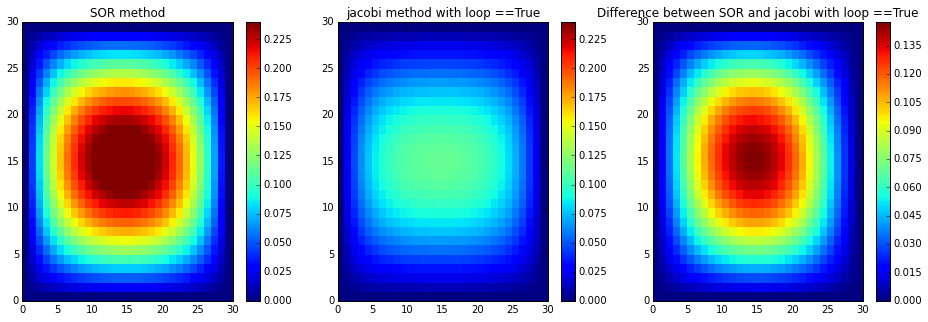

In [6]:
cmap = plt.get_cmap('jet')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,5))
plot1 = ax1.pcolormesh(np.transpose(psi_sor),cmap =cmap,vmin=0, vmax=0.24)
fig.colorbar(plot1, ax=ax1)
ax1.set_title('SOR method')
plot2 = ax2.pcolormesh(np.transpose(psi_jacobi),cmap =cmap,vmin=0, vmax=0.24)
fig.colorbar(plot2, ax=ax2)
ax2.set_title('jacobi method with loop ==True')
plot3 =ax3.pcolormesh(np.transpose(psi_sor) - np.transpose(psi_jacobi),cmap =cmap)
fig.colorbar(plot3, ax=ax3)
ax3.set_title('Difference between SOR and jacobi with loop ==True')

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


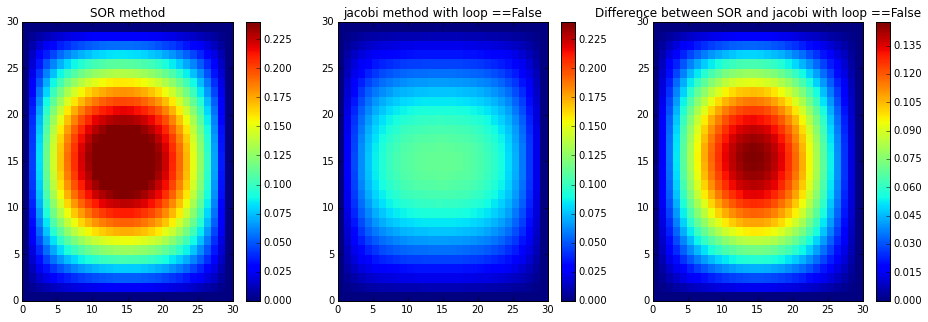

In [7]:
cmap = plt.get_cmap('jet')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,5))
plot1 = ax1.pcolormesh(np.transpose(psi_sor),cmap =cmap,vmin=0, vmax=0.24)
fig.colorbar(plot1, ax=ax1)
ax1.set_title('SOR method')
plot2 = ax2.pcolormesh(np.transpose(psi_jacobi2),cmap =cmap,vmin=0, vmax=0.24)
fig.colorbar(plot2, ax=ax2)
ax2.set_title('jacobi method with loop ==False')
plot3 =ax3.pcolormesh(np.transpose(psi_sor) - np.transpose(psi_jacobi),cmap =cmap)
fig.colorbar(plot3, ax=ax3)
ax3.set_title('Difference between SOR and jacobi with loop ==False')

* Question I: From the above comparisons, we can see that the most efficient method is jacobi iteration method by setting loop == False, as it accounts for the least compute time. However, SOR method converges faster than jacobi method which takes fewer iteration numbers than jacobi ones.

# Change depth only

In [3]:
import qg1

Physical Parameters:
Depth H = 100.0

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
count_total is: 299


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


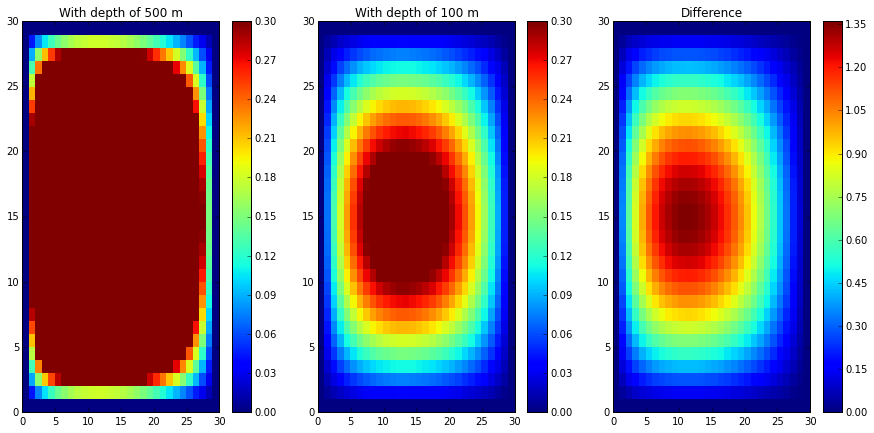

In [14]:
## depth from 500m to 100m now
reload (qg1)
psi_sor_depth = qg1.qg(1e6,loop = False)
psi_sor = qg(1e6, loop=False)

cmap  ='jet'
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,7))
plot1 = ax1.pcolormesh(np.transpose(psi_sor),cmap =cmap,vmin=0, vmax=0.3)
ax1.set_title("With depth of 500 m ")
fig.colorbar(plot1, ax=ax1); 
plot2 = ax2.pcolormesh(np.transpose(psi_sor_depth),cmap =cmap,vmin=0, vmax=0.3)
fig.colorbar(plot2, ax=ax2)
ax2.set_title("With depth of 100 m ")
plot3 =ax3.pcolormesh(np.transpose(psi_sor) - np.transpose(psi_sor_depth),cmap =cmap)
fig.colorbar(plot3, ax=ax3)
ax3.set_title("Difference")

Physical Parameters:
Depth H = 1000.0

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
count_total is: 299


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


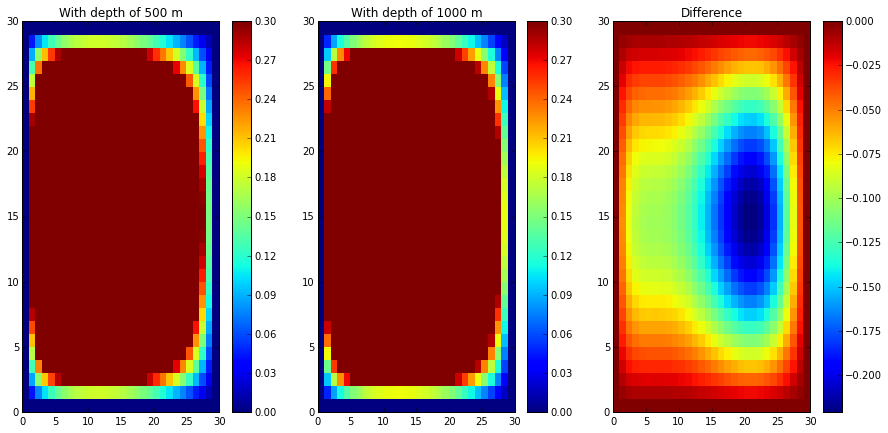

In [10]:
## depth from 500m to 1000m now
reload (qg1)
psi_sor_depth = qg1.qg(1e6,loop = False)
psi_sor = qg(1e6, loop=False)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,7))
plot1 = ax1.pcolormesh(np.transpose(psi_sor),cmap =cmap,vmin=0, vmax=0.3)
ax1.set_title("With depth of 500 m ")
fig.colorbar(plot1, ax=ax1); 
plot2 = ax2.pcolormesh(np.transpose(psi_sor_depth),cmap =cmap,vmin=0, vmax=0.3)
fig.colorbar(plot2, ax=ax2)
ax2.set_title("With depth of 1000 m ")
plot3 =ax3.pcolormesh(np.transpose(psi_sor) - np.transpose(psi_sor_depth),cmap =cmap)
fig.colorbar(plot3, ax=ax3)
ax3.set_title("Difference")

Physical Parameters:
Depth H = 4000.0

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


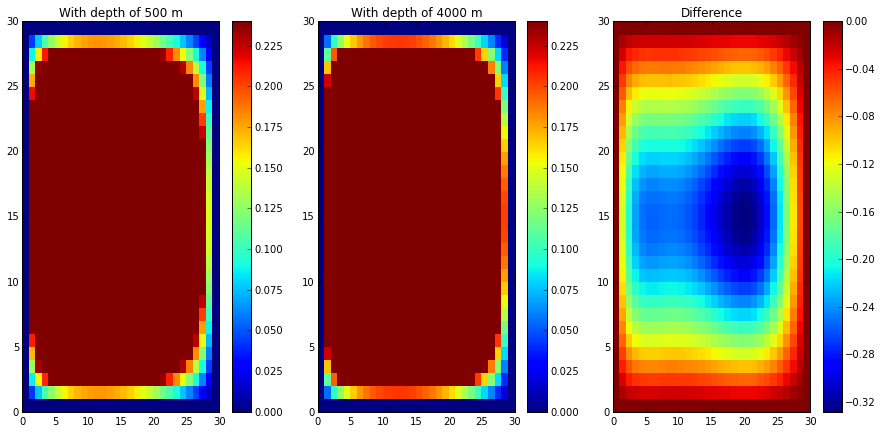

In [12]:
## from depth 500m to 4000m now
reload (qg1)
psi_sor_depth = qg1.qg(1e6,loop = False)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,7))
plot1 = ax1.pcolormesh(np.transpose(psi_sor),cmap =cmap,vmin=0, vmax=0.24)
ax1.set_title("With depth of 500 m ")
fig.colorbar(plot1, ax=ax1); 
plot2 = ax2.pcolormesh(np.transpose(psi_sor_depth),cmap =cmap,vmin=0, vmax=0.24)
fig.colorbar(plot2, ax=ax2)
ax2.set_title("With depth of 4000 m ")
plot3 =ax3.pcolormesh(np.transpose(psi_sor) - np.transpose(psi_sor_depth),cmap =cmap)
fig.colorbar(plot3, ax=ax3)
ax3.set_title("Difference")

* By changing the depth, we can see that the difference of streamlines always occurs at the boundary. Due to the Sverdrup balance, $\frac{\beta v}{f}$ = $- \frac{\zeta \delta}{2H}$, where $\zeta$ = $\nabla \times \vec{\tau} >0$ in this case, $\zeta$ is the thickness of boundary layer. f is constant in this case, $\beta$ is not variable either. When depth H increases, maginitude of v decreases and it is still negative, which corresponds with the difference plot above and when H decreases, vice versa. Besides, with H increases, larger value of streamline at the same spatial space compared with small H case, that shows stronger v velocity which corresponds with the formula as well.

# Put Gaussian function on the 3/4 of the way 

In [2]:
def gaussian(ngrid):
    """This function was made to create a gaussian function on the 3/4 of the 
    way of X"""
    x = np.arange(0, ngrid, 1, float)
    y = x[:,np.newaxis]; x0=ngrid/4*3; y0=ngrid/2;
    fwhm = 80/200*ngrid
    gauss=2*np.exp(-6*((x-x0)**2 + (y-y0)**2) / fwhm**2)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, gauss, rstride=8, cstride=8, alpha=0.3, color = 'tomato')
    cset = ax.contour(X, Y, gauss, zdir='z', offset=gauss.min(), cmap=cm.coolwarm)
    cset = ax.contour(X, Y, gauss, zdir='x', offset=X.min(), cmap=cm.coolwarm)
    cset = ax.contour(X, Y, gauss, zdir='y', offset=Y.max(), cmap=cm.coolwarm)
    ax.set_xlabel('X grid')
    ax.set_ylabel('Y grid')
    ax.set_zlabel('Z grid')
    return gauss

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


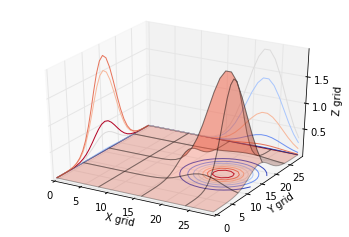

In [3]:
## ngrid = 30
gauss = gaussian(30)

In [4]:
import qg2

Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
count_total is: 100
Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =  1.0
count_total is: 399
Physical Parameters:
a =  2000000.0
b =  2000000.0
epsilon =  0.000193627808795
wind =  -1.0
vis =  0.0997836584831
time =  31114.9328133
boundary_layer_width_approx =  199567.316966

Simulation Parameters:
nx =  30
dx =  0.034482758620689655
ny =  30
dt =  43200.0
maximum iterations =  50
tolerance = 0.005
coeff =

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


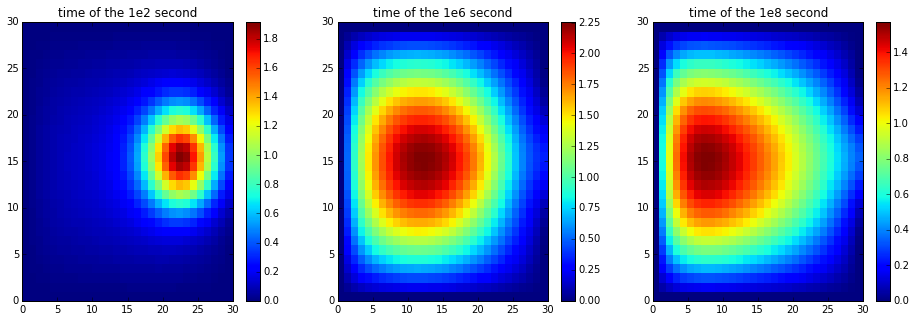

In [17]:
qg_gauss0 = qg2.qg(gauss, 1e2,loop = False,flag = 'jacobi')
qg_gauss1 = qg2.qg(gauss, 1e6,loop = False,flag = 'jacobi')
qg_gauss2 = qg2.qg(gauss, 1e8,loop = False,flag = 'jacobi')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,5))
plot1 = ax1.pcolormesh(np.transpose(qg_gauss0),cmap =cmap)
fig.colorbar(plot1, ax=ax1)
ax1.set_title('time of the 1e2 second')
plot2 = ax2.pcolormesh(np.transpose(qg_gauss1),cmap =cmap)
fig.colorbar(plot2, ax=ax2)
ax2.set_title('time of the 1e6 second')
plot3 =ax3.pcolormesh(np.transpose(qg_gauss2),cmap =cmap)
fig.colorbar(plot3, ax=ax3)
ax3.set_title('time of the 1e8 second')

* Question 3:
Change in codes: the initial condition part for psi_1 and psi_2 are:


* By examining patterns of streamlines for different duration time, we found the timescale of 1e7 is the time for the westward movement reach steady state in this case as the patterns are the same with timescale of 1e8 and 1e7.